## Pipeline:
1.Get ACS **tract level data** by APIs

2.Get mobility **tract level** pattern data from SafeGraph

3.Get New York Census Tract data from arcgis hub

In [180]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import geopandas as gpd

from shapely.geometry import shape, Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt

import geojson
import json
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 10]
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.float_format', '{:.2f}'.format)


### 1. NYC base map on tract level

https://www1.nyc.gov/site/planning/data-maps/open-data/census-download-metadata.page


In [181]:
### tract level data:
url='https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Census_Tracts_for_2020_US_Census/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'

In [182]:
import geojson
r_1=requests.get(url)
features_1 = geojson.loads(r_1.text)

In [183]:
GEOID,geometry=[],[]

for e in features_1['features']: 
    GEOID.append(e['properties']["GEOID"])
    ps = shape(e['geometry'])
    geometry.append(
        MultiPolygon(ps) if isinstance(ps, list) else ps
    )

boundary = pd.DataFrame([GEOID,geometry]).T
boundary.columns=['GEO_ID','geometry']
boundary['tract_id']=boundary['GEO_ID'].str[:11].astype('int64')


In [184]:
boundary_gpd= gpd.GeoDataFrame(boundary, geometry='geometry', crs="EPSG:4326")
boundary_gpd.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

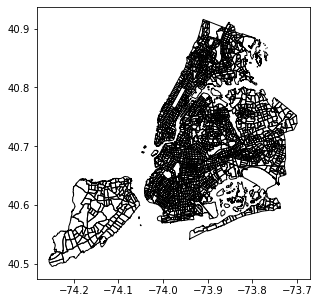

In [185]:
fig, ax = plt.subplots(figsize=(5,5))
ax = boundary_gpd.plot(ax=ax, facecolor='none', edgecolor='black')
ax

### 2. ACS 5-year data based on tract level

Data dictionary:

                'B03001_003E':'total_pop', 
                'B03002_003E':'Whites not Hispanic or Latino',
                'B03002_004E':'Black not Hispanic or Latino',
                'B03002_005E':'Indian and Alaska Native not Hispanic or Latino',
                'B03002_006E':'Asian not Hispanic or Latino',
                'B03001_003E': 'Hispanic',
    
                'B15001_050E':'FemaleBachelors', 
                'B15001_009E':'MaleBachelors',
    
                'B19013_001E':'MedHHInc',
                'B25058_001E':'MedRent',
    
                'B08201_002E': 'NoCar',
                'B08201_003E': 'OneCar',
                'B08201_004E': 'TwoCar',
                'B08201_005E': 'ThreeCar',
                'B08201_006E': 'FourMoreCar',
    
                'B08201_001E': 'TotalHousehold',
                'B06012_002E':'TotalPoverty',
                'B25002_003E':'TotalVacant',
                'B25001_001E':'TotalUnit',


In [186]:
http='https://api.census.gov/data/2019/acs/acs5?get=NAME,GEO_ID,B03003_001E,B03001_003E,B03002_003E,B03002_004E,B03002_005E,B03002_006E,B15001_050E,B15001_009E,B06012_002E,B25002_003E,B25001_001E,B25058_001E,B19013_001E,B08201_002E,B08201_003E,B08201_004E,B08201_005E,B08201_006E,B08201_001E&for=tract:*&in=state:36%20county:085,081,061,005,047&key=9e5876bd913ec7705eb4b93ee17937abb9bf8d2b'

In [187]:
r_2=requests.get(http)
features_2 = r_2.json()
acs=pd.DataFrame.from_records(features_2)
new_header=acs.iloc[0]
acs.head()# features.to_csv('census.csv')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,NAME,GEO_ID,B03003_001E,B03001_003E,B03002_003E,B03002_004E,B03002_005E,B03002_006E,B15001_050E,B15001_009E,B06012_002E,B25002_003E,B25001_001E,B25058_001E,B19013_001E,B08201_002E,B08201_003E,B08201_004E,B08201_005E,B08201_006E,B08201_001E,state,county,tract
1,"Census Tract 361, Queens County, New York",1400000US36081036100,2238,1449,73,378,0,323,16,8,290,200,818,1346,47419,264,196,137,21,0,618,36,081,036100
2,"Census Tract 363, Queens County, New York",1400000US36081036300,1771,1290,66,263,0,115,7,9,359,235,732,1441,57802,240,196,44,17,0,497,36,081,036300
3,"Census Tract 371, Queens County, New York",1400000US36081037100,1335,724,19,309,0,200,0,5,158,191,593,1769,67419,92,190,100,20,0,402,36,081,037100
4,"Census Tract 377, Queens County, New York",1400000US36081037700,3620,3260,17,191,0,152,11,11,439,128,903,1647,71728,448,222,81,24,0,775,36,081,037700


In [188]:
new_header=acs.iloc[0]
acs.columns=new_header
acs=acs[1:]
acs=acs.rename({

                'B03003_001E':'total_pop', 
                'B03002_003E':'Whites',
                'B03002_004E':'Black',
                'B03002_005E':'Indian',
                'B03002_006E':'Asian',
                'B03001_003E': 'Hispanic',
    
                'B15001_050E':'FemaleBachelors', 
                'B15001_009E':'MaleBachelors',
    
                'B19013_001E':'MedHHInc',
                'B25058_001E':'MedRent',
    
                'B08201_002E': 'NoCar',
                'B08201_003E': 'OneCar',
                'B08201_004E': 'TwoCar',
                'B08201_005E': 'ThreeCar',
                'B08201_006E': 'FourMoreCar',
    
                'B08201_001E': 'TotalHousehold',
                'B06012_002E':'TotalPoverty',
                'B25002_003E':'TotalVacant',
                'B25001_001E':'TotalUnit',

               }, axis='columns')
print(acs.shape)
acs=acs.dropna()
print(acs.shape)
acs['tract_id']=pd.to_numeric(acs['GEO_ID'].str[9:])
acs.head()

(2167, 24)
(2167, 24)


,NAME,GEO_ID,total_pop,Hispanic,Whites,Black,Indian,Asian,FemaleBachelors,MaleBachelors,TotalPoverty,TotalVacant,TotalUnit,MedRent,MedHHInc,NoCar,OneCar,TwoCar,ThreeCar,FourMoreCar,TotalHousehold,state,county,tract,tract_id
1,"Census Tract 361, Queens County, New York",1400000US36081036100,2238,1449,73,378,0,323,16,8,290,200,818,1346,47419,264,196,137,21,0,618,36,081,036100,36081036100
2,"Census Tract 363, Queens County, New York",1400000US36081036300,1771,1290,66,263,0,115,7,9,359,235,732,1441,57802,240,196,44,17,0,497,36,081,036300,36081036300
3,"Census Tract 371, Queens County, New York",1400000US36081037100,1335,724,19,309,0,200,0,5,158,191,593,1769,67419,92,190,100,20,0,402,36,081,037100,36081037100
4,"Census Tract 377, Queens County, New York",1400000US36081037700,3620,3260,17,191,0,152,11,11,439,128,903,1647,71728,448,222,81,24,0,775,36,081,037700,36081037700
5,"Census Tract 379, Queens County, New York",1400000US36081037900,6851,5962,63,271,0,535,45,0,1115,40,1423,1551,72799,737,455,174,10,7,1383,36,081,037900,36081037900


In [189]:
acs['total_pop']=acs['total_pop'].astype('int64')
acs['Whites']=acs['Whites'].astype('int32')
acs['Black']=acs['Black'].astype('int64')
acs['Indian']=acs['Indian'].astype('int64')
acs['Asian']=acs['Asian'].astype('int64')
acs['Hispanic']=acs['Asian'].astype('int64')

acs['FemaleBachelors']=acs['FemaleBachelors'].astype('int64')
acs['MaleBachelors']=acs['MaleBachelors'].astype('int64')

acs['MedHHInc']=acs['MedHHInc'].astype('int64')
acs['MedRent']=acs['MedRent'].astype('int64')

acs['NoCar']=acs['NoCar'].astype('int64')
acs['OneCar']=acs['OneCar'].astype('int64')
acs['TwoCar']=acs['TwoCar'].astype('int64')
acs['ThreeCar']=acs['ThreeCar'].astype('int64')
acs['FourMoreCar']=acs['FourMoreCar'].astype('int64')

acs['TotalHousehold']=acs['TotalHousehold'].astype('int64')
acs['TotalPoverty']=acs['TotalPoverty'].astype('int64')
acs['TotalVacant']=acs['TotalVacant'].astype('int64')
acs['TotalUnit']=acs['TotalUnit'].astype('int64')


In [190]:
print(acs.shape)
# acs.drop(acs[acs['MedHHInc'] <0].index, inplace = True)
print(acs.shape)

(2167, 25)
(2167, 25)


In [191]:
# verfication
acs.values[:4,14:15]
acs.quantile(q=0.25,axis=0)
bot_quantile=np.quantile(acs.values[:4,14:15],0.25,axis=0)
bot_quantile=bot_quantile[0]
bot_quantile
top_quantile=np.quantile(acs.values[:4,14:15],0.75,axis=0)
top_quantile=top_quantile[0]
top_quantile

68496.25

In [192]:
top_quantile=np.quantile(acs.values[:,14:15],0.75,axis=0)
top_quantile=top_quantile[0]
bot_quantile=np.quantile(acs.values[:,14:15],0.25,axis=0)
bot_quantile=bot_quantile[0]
acs.loc[acs['MedHHInc'] >=top_quantile, 'income_quantile'] = 'Top'
acs.loc[acs['MedHHInc'] <=bot_quantile, 'income_quantile'] = 'Bot'
acs.loc[(bot_quantile<acs['MedHHInc']) & (acs['MedHHInc']  <top_quantile), 'income_quantile'] = 'Mid'

print(acs.shape)
print(acs.loc[acs['MedHHInc'] >=top_quantile].shape)
print(acs.loc[acs['MedHHInc'] <=bot_quantile].shape)
acs.head()

(2167, 26)
(542, 26)
(542, 26)


,NAME,GEO_ID,total_pop,Hispanic,Whites,Black,Indian,Asian,FemaleBachelors,MaleBachelors,TotalPoverty,TotalVacant,TotalUnit,MedRent,MedHHInc,NoCar,OneCar,TwoCar,ThreeCar,FourMoreCar,TotalHousehold,state,county,tract,tract_id,income_quantile
1,"Census Tract 361, Queens County, New York",1400000US36081036100,2238,323,73,378,0,323,16,8,290,200,818,1346,47419,264,196,137,21,0,618,36,081,036100,36081036100,Mid
2,"Census Tract 363, Queens County, New York",1400000US36081036300,1771,115,66,263,0,115,7,9,359,235,732,1441,57802,240,196,44,17,0,497,36,081,036300,36081036300,Mid
3,"Census Tract 371, Queens County, New York",1400000US36081037100,1335,200,19,309,0,200,0,5,158,191,593,1769,67419,92,190,100,20,0,402,36,081,037100,36081037100,Mid
4,"Census Tract 377, Queens County, New York",1400000US36081037700,3620,152,17,191,0,152,11,11,439,128,903,1647,71728,448,222,81,24,0,775,36,081,037700,36081037700,Mid
5,"Census Tract 379, Queens County, New York",1400000US36081037900,6851,535,63,271,0,535,45,0,1115,40,1423,1551,72799,737,455,174,10,7,1383,36,081,037900,36081037900,Mid


In [193]:
# acs['majority_white'] = np.where((acs['white_pop']/acs['total_pop'])>=0.5, True, False)
acs['pctWhite'] = (acs['Whites']/acs['total_pop'])
acs['pctBlack'] = (acs['Black']/acs['total_pop'])
acs['pctIndian'] = (acs['Indian']/acs['total_pop'])
acs['pctAsian'] = (acs['Asian']/acs['total_pop'])
acs['pctHispanic'] = (acs['Hispanic']/acs['total_pop'])

acs['pctVacant'] = (acs['TotalVacant']/acs['TotalUnit'])
acs['pctBachelors'] = (acs['FemaleBachelors']+acs['MaleBachelors'])/acs['total_pop']
acs['pctPoverty'] = acs['TotalPoverty']/acs['total_pop']

acs['average_car']=(acs['NoCar']*0+acs['OneCar']+acs['TwoCar']*2+
                    acs['ThreeCar']*3+acs['FourMoreCar']*4)/acs['TotalHousehold']

### todo: car ownership
acs.to_csv('../data_save/acs.csv')
# acs.head()


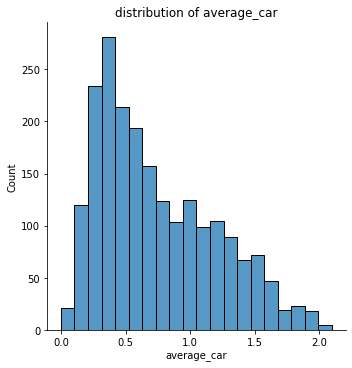

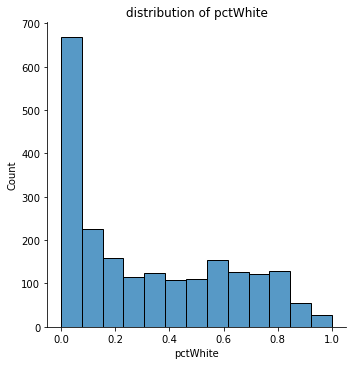

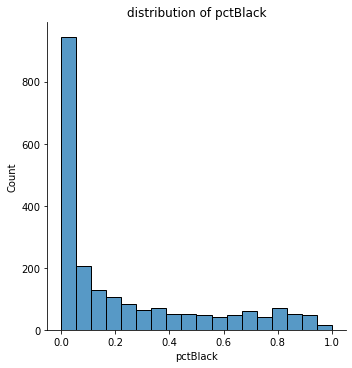

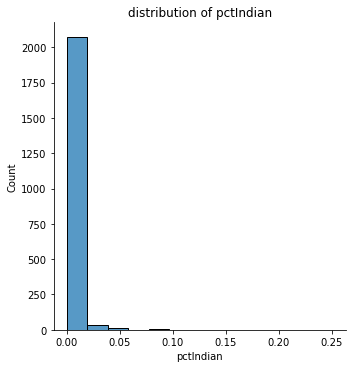

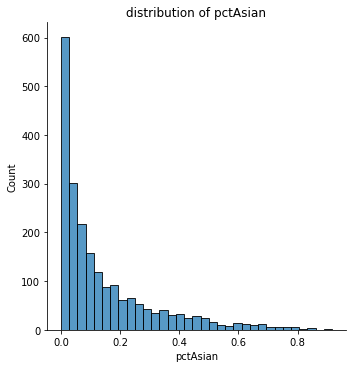

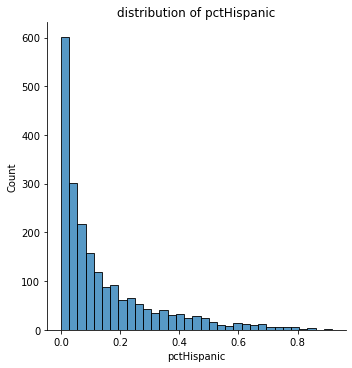

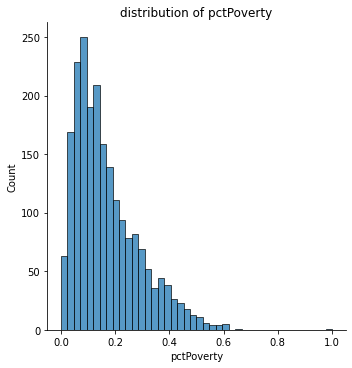

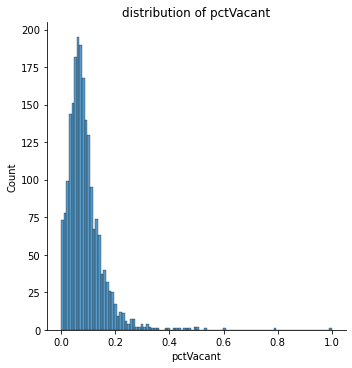

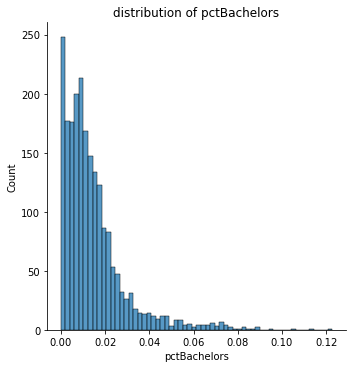

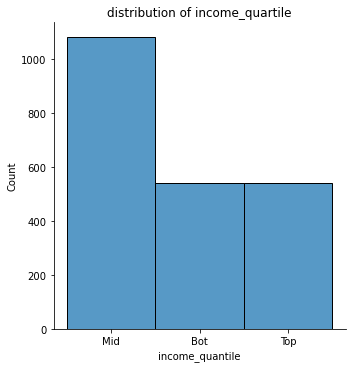

In [194]:
sns.displot(acs, x="average_car").set(title='distribution of average_car')
sns.displot(acs, x="pctWhite").set(title='distribution of pctWhite')
sns.displot(acs, x="pctBlack").set(title='distribution of pctBlack')
sns.displot(acs, x="pctIndian").set(title='distribution of pctIndian')
sns.displot(acs, x="pctAsian").set(title='distribution of pctAsian')
sns.displot(acs, x="pctHispanic").set(title='distribution of pctHispanic')
sns.displot(acs, x="pctPoverty").set(title='distribution of pctPoverty')
sns.displot(acs, x="pctVacant").set(title='distribution of pctVacant')
sns.displot(acs, x="pctBachelors").set(title='distribution of pctBachelors')
sns.displot(acs, x="income_quantile").set(title='distribution of income_quartile')


### 3 .Pattern data from SafeGraph

##### 3.1 business type aggravagation from 2-digit naics code 

In [195]:
df_mar_19=pd.read_csv('../data_save/df_mar_19.csv')  
df_mar_20=pd.read_csv('../data_save/df_mar_20.csv')  
df_mar_21=pd.read_csv('../data_save/df_mar_21.csv') 

##### 3.2 groupby tract_id and calculate sum of:

1. raw_visit_counts, 

2. raw_visitor_counts

In [196]:
tract_mar_19=df_mar_19.groupby(by=['tract_id'])['raw_visit_counts'].sum()
print(tract_mar_19.shape)
tract_mar_19.head()
tract_mar_19.to_csv('../data_save/tract_mar_19.csv')

(1292,)


In [197]:
tract_mar_20=df_mar_20.groupby(by=['tract_id'])['raw_visit_counts'].sum()
print(tract_mar_20.shape)
tract_mar_20.to_csv('../data_save/tract_mar_20.csv')

(1281,)


In [198]:
tract_mar_21=df_mar_21.groupby(by=['tract_id'])['raw_visit_counts'].sum()
print(tract_mar_21.shape)
tract_mar_21.head()
tract_mar_21.to_csv('../data_save/tract_mar_21.csv')

(1276,)


In [199]:
def spatial_process(raw_data):
    # merge pattern data and acs 5-year data based on tract_id
    pattern_acs = pd.merge(raw_data, acs,how='left',left_on=['tract_id'],right_on=['tract_id'])
    
    # merge pattern_acs(acs+pattern data) with boundary(NYC base map) by tract_id
    data_merge=pd.merge(pattern_acs, boundary,how='inner',left_on=['tract_id'],right_on=['tract_id'])
    
    data_merge.loc[data_merge["county"] == '005','county'] = 'Bronx'
    data_merge.loc[data_merge["county"] == '047','county'] = 'Brooklyn'
    data_merge.loc[data_merge["county"] == '061','county'] = 'Manhattan'
    data_merge.loc[data_merge["county"] == '081','county'] = 'Queens'
    data_merge.loc[data_merge["county"] == '085','county'] = 'Staten Dislands'
    
    # transfer to geodata 
    gdf= gpd.GeoDataFrame(data_merge, geometry='geometry', crs="EPSG:4326")
    return pattern_acs,data_merge,gdf


In [200]:
_,_,gdf_mar_19=spatial_process(tract_mar_19)
gdf_mar_19.to_csv('../data_save/gdf_mar_19.csv')
gdf_mar_19.head()


,tract_id,raw_visit_counts,NAME,GEO_ID_x,total_pop,Hispanic,Whites,Black,Indian,Asian,FemaleBachelors,MaleBachelors,TotalPoverty,TotalVacant,TotalUnit,MedRent,MedHHInc,NoCar,OneCar,TwoCar,ThreeCar,FourMoreCar,TotalHousehold,state,county,tract,income_quantile,pctWhite,pctBlack,pctIndian,pctAsian,pctHispanic,pctVacant,pctBachelors,pctPoverty,average_car,GEO_ID_y,geometry
0,36005000200,835,"Census Tract 2, Bronx County, New York",1400000US36005000200,4532.00,75.00,33.00,920.00,0.00,75.00,0.00,0.00,1017.00,157.00,1499.00,1454.00,51100.00,340.00,666.00,291.00,45.00,0.00,1342.00,36,Bronx,000200,Mid,0.01,0.20,0.00,0.02,0.02,0.10,0.00,0.22,1.03,36005000200,"POLYGON ((-73.85652 40.80525, -73.85653 40.805..."
1,36005000400,3986,"Census Tract 4, Bronx County, New York",1400000US36005000400,5516.00,121.00,387.00,1264.00,0.00,121.00,67.00,0.00,462.00,141.00,2183.00,1241.00,78409.00,417.00,968.00,523.00,84.00,50.00,2042.00,36,Bronx,000400,Mid,0.07,0.23,0.00,0.02,0.02,0.06,0.01,0.08,1.21,36005000400,"POLYGON ((-73.84611 40.81311, -73.84647 40.812..."
2,36005001600,337,"Census Tract 16, Bronx County, New York",1400000US36005001600,5825.00,64.00,213.00,2021.00,0.00,64.00,24.00,39.00,1522.00,45.00,2016.00,953.00,34093.00,1051.00,687.00,209.00,24.00,0.00,1971.00,36,Bronx,001600,Bot,0.04,0.35,0.00,0.01,0.01,0.02,0.01,0.26,0.60,36005001600,"POLYGON ((-73.85514 40.82244, -73.85497 40.821..."
3,36005002300,1813,"Census Tract 23, Bronx County, New York",1400000US36005002300,4302.00,0.00,1.00,1192.00,16.00,0.00,16.00,0.00,1695.00,0.00,1914.00,436.00,18688.00,1576.00,323.00,12.00,3.00,0.00,1914.00,36,Bronx,002300,Bot,0.00,0.28,0.00,0.00,0.00,0.00,0.00,0.39,0.19,36005002300,"POLYGON ((-73.92289 40.80911, -73.92324 40.808..."
4,36005002400,5984,"Census Tract 24, Bronx County, New York",1400000US36005002400,155.00,0.00,65.00,90.00,0.00,0.00,0.00,0.00,0.00,0.00,38.00,-666666666.00,-666666666.00,38.00,0.00,0.00,0.00,0.00,38.00,36,Bronx,002400,Bot,0.42,0.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,36005002400,"POLYGON ((-73.87050 40.82037, -73.87044 40.820..."


In [201]:
_,_,gdf_mar_20=spatial_process(tract_mar_20)
gdf_mar_20.to_csv('../data_save/gdf_mar_20.json')
gdf_mar_20.head()


,tract_id,raw_visit_counts,NAME,GEO_ID_x,total_pop,Hispanic,Whites,Black,Indian,Asian,FemaleBachelors,MaleBachelors,TotalPoverty,TotalVacant,TotalUnit,MedRent,MedHHInc,NoCar,OneCar,TwoCar,ThreeCar,FourMoreCar,TotalHousehold,state,county,tract,income_quantile,pctWhite,pctBlack,pctIndian,pctAsian,pctHispanic,pctVacant,pctBachelors,pctPoverty,average_car,GEO_ID_y,geometry
0,36005000200,451,"Census Tract 2, Bronx County, New York",1400000US36005000200,4532.00,75.00,33.00,920.00,0.00,75.00,0.00,0.00,1017.00,157.00,1499.00,1454.00,51100.00,340.00,666.00,291.00,45.00,0.00,1342.00,36,Bronx,000200,Mid,0.01,0.20,0.00,0.02,0.02,0.10,0.00,0.22,1.03,36005000200,"POLYGON ((-73.85652 40.80525, -73.85653 40.805..."
1,36005000400,1970,"Census Tract 4, Bronx County, New York",1400000US36005000400,5516.00,121.00,387.00,1264.00,0.00,121.00,67.00,0.00,462.00,141.00,2183.00,1241.00,78409.00,417.00,968.00,523.00,84.00,50.00,2042.00,36,Bronx,000400,Mid,0.07,0.23,0.00,0.02,0.02,0.06,0.01,0.08,1.21,36005000400,"POLYGON ((-73.84611 40.81311, -73.84647 40.812..."
2,36005001600,119,"Census Tract 16, Bronx County, New York",1400000US36005001600,5825.00,64.00,213.00,2021.00,0.00,64.00,24.00,39.00,1522.00,45.00,2016.00,953.00,34093.00,1051.00,687.00,209.00,24.00,0.00,1971.00,36,Bronx,001600,Bot,0.04,0.35,0.00,0.01,0.01,0.02,0.01,0.26,0.60,36005001600,"POLYGON ((-73.85514 40.82244, -73.85497 40.821..."
3,36005002300,1309,"Census Tract 23, Bronx County, New York",1400000US36005002300,4302.00,0.00,1.00,1192.00,16.00,0.00,16.00,0.00,1695.00,0.00,1914.00,436.00,18688.00,1576.00,323.00,12.00,3.00,0.00,1914.00,36,Bronx,002300,Bot,0.00,0.28,0.00,0.00,0.00,0.00,0.00,0.39,0.19,36005002300,"POLYGON ((-73.92289 40.80911, -73.92324 40.808..."
4,36005002400,4568,"Census Tract 24, Bronx County, New York",1400000US36005002400,155.00,0.00,65.00,90.00,0.00,0.00,0.00,0.00,0.00,0.00,38.00,-666666666.00,-666666666.00,38.00,0.00,0.00,0.00,0.00,38.00,36,Bronx,002400,Bot,0.42,0.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,36005002400,"POLYGON ((-73.87050 40.82037, -73.87044 40.820..."


In [202]:
columns_1=['raw_visit_counts','tract_id',
        'income_quantile','pctWhite','pctBlack','pctIndian','pctAsian','pctHispanic','pctVacant','pctBachelors','pctPoverty','average_car'
        ]


In [203]:
_,_,gdf_mar_21=spatial_process(tract_mar_21)
gdf_mar_21=gdf_mar_21.dropna(subset=columns_1)
gdf_mar_21.to_csv('../data_save/gdf_mar_21.csv')
gdf_mar_21.head()

,tract_id,raw_visit_counts,NAME,GEO_ID_x,total_pop,Hispanic,Whites,Black,Indian,Asian,FemaleBachelors,MaleBachelors,TotalPoverty,TotalVacant,TotalUnit,MedRent,MedHHInc,NoCar,OneCar,TwoCar,ThreeCar,FourMoreCar,TotalHousehold,state,county,tract,income_quantile,pctWhite,pctBlack,pctIndian,pctAsian,pctHispanic,pctVacant,pctBachelors,pctPoverty,average_car,GEO_ID_y,geometry
0,36005000200,493,"Census Tract 2, Bronx County, New York",1400000US36005000200,4532.00,75.00,33.00,920.00,0.00,75.00,0.00,0.00,1017.00,157.00,1499.00,1454.00,51100.00,340.00,666.00,291.00,45.00,0.00,1342.00,36,Bronx,000200,Mid,0.01,0.20,0.00,0.02,0.02,0.10,0.00,0.22,1.03,36005000200,"POLYGON ((-73.85652 40.80525, -73.85653 40.805..."
1,36005000400,2008,"Census Tract 4, Bronx County, New York",1400000US36005000400,5516.00,121.00,387.00,1264.00,0.00,121.00,67.00,0.00,462.00,141.00,2183.00,1241.00,78409.00,417.00,968.00,523.00,84.00,50.00,2042.00,36,Bronx,000400,Mid,0.07,0.23,0.00,0.02,0.02,0.06,0.01,0.08,1.21,36005000400,"POLYGON ((-73.84611 40.81311, -73.84647 40.812..."
2,36005001600,81,"Census Tract 16, Bronx County, New York",1400000US36005001600,5825.00,64.00,213.00,2021.00,0.00,64.00,24.00,39.00,1522.00,45.00,2016.00,953.00,34093.00,1051.00,687.00,209.00,24.00,0.00,1971.00,36,Bronx,001600,Bot,0.04,0.35,0.00,0.01,0.01,0.02,0.01,0.26,0.60,36005001600,"POLYGON ((-73.85514 40.82244, -73.85497 40.821..."
3,36005002300,700,"Census Tract 23, Bronx County, New York",1400000US36005002300,4302.00,0.00,1.00,1192.00,16.00,0.00,16.00,0.00,1695.00,0.00,1914.00,436.00,18688.00,1576.00,323.00,12.00,3.00,0.00,1914.00,36,Bronx,002300,Bot,0.00,0.28,0.00,0.00,0.00,0.00,0.00,0.39,0.19,36005002300,"POLYGON ((-73.92289 40.80911, -73.92324 40.808..."
4,36005002400,2986,"Census Tract 24, Bronx County, New York",1400000US36005002400,155.00,0.00,65.00,90.00,0.00,0.00,0.00,0.00,0.00,0.00,38.00,-666666666.00,-666666666.00,38.00,0.00,0.00,0.00,0.00,38.00,36,Bronx,002400,Bot,0.42,0.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,36005002400,"POLYGON ((-73.87050 40.82037, -73.87044 40.820..."


In [204]:
gdf_mar_21.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [205]:
import shapely
def df_to_geojson(df, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Polygon',
                               'coordinates':[]}}
        
        feature['geometry']= shapely.geometry.mapping(row.geometry)
        for prop in columns_1:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

geojson_19 =df_to_geojson(gdf_mar_21)

from geojson import Point, Feature, FeatureCollection, dump

# with open('../data_save/gdf_mar_19.geojson', 'w') as f:
#    dump(geojson_19, f)

# geojson_20 =df_to_geojson(gdf_mar_20)

# with open('../data_save/gdf_mar_20.geojson', 'w') as f:
#    dump(geojson_20, f)

gdf_mar_21_js =df_to_geojson(gdf_mar_21)

with open('../data_save/gdf_mar_21.geojson', 'w') as f:
   dump(gdf_mar_21_js, f)

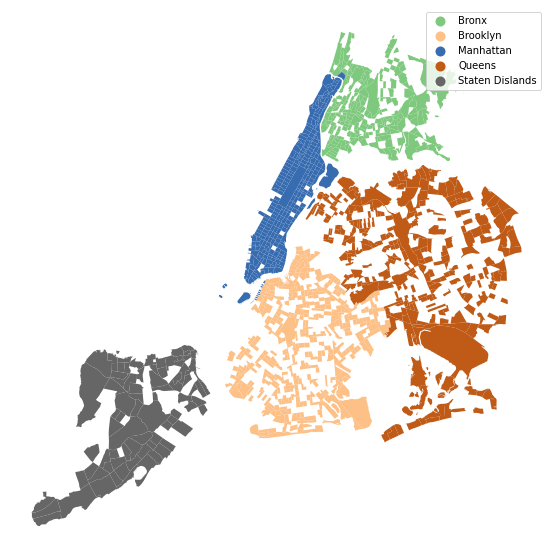

In [207]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral')
fig, ax = plt.subplots(figsize=(10,10))

# Plot the choropleth,threshold>0.5
gdf_mar_20.plot(ax=ax, column='county',categorical='True',cmap='Accent' , legend=True)
# Format
# ax.set_title("Map of NYC", fontsize=16)
ax.set_axis_off()
fig.savefig('../fig/NYC_map.jpg')

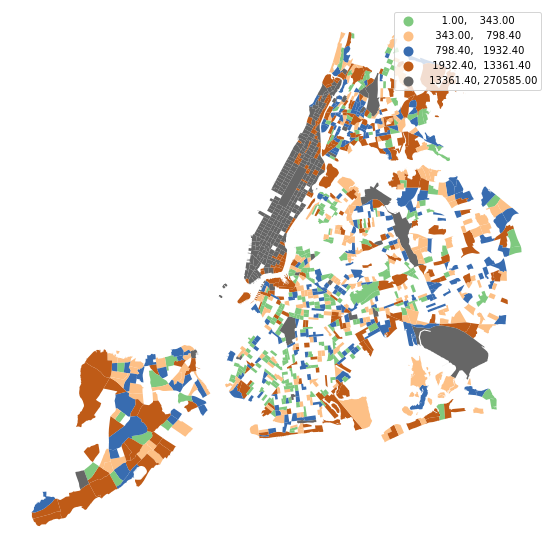

In [209]:

fig, ax = plt.subplots(figsize=(10,10))

# Plot the choropleth,threshold>0.5
plot1=gdf_mar_19.plot(ax=ax, column='raw_visit_counts',
                    scheme='Quantiles',cmap='Accent',
                    legend=True,
#                     legend_kwargs={ 'loc': 'lower right'},
                   )

# Format
# ax.set_title("visit count of NY in march 2019", fontsize=16)

# ax.legend(loc='lower left')
ax.set_axis_off()
fig.savefig('../fig/raw_visit_counts_mar_2019.jpg')

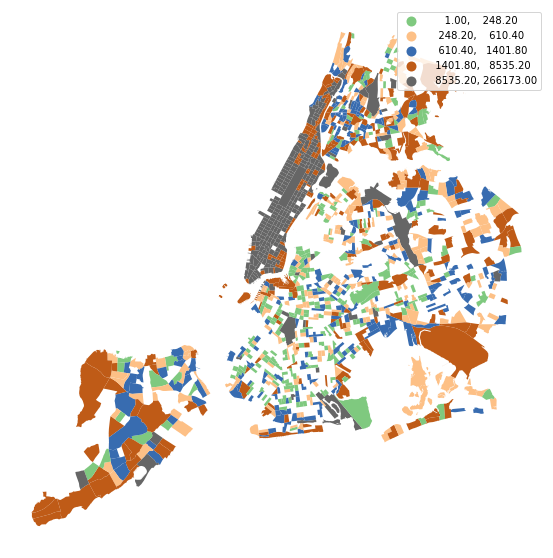

In [210]:

fig, ax = plt.subplots(figsize=(10,10))

# Plot the choropleth,threshold>0.5
plot1=gdf_mar_20.plot(ax=ax, column='raw_visit_counts',
                    scheme='Quantiles',cmap='Accent',
                    legend=True,
#                     legend_kwargs={ 'loc': 'lower right'},
                   )

# Format
# ax.set_title("visit count of NY in march 2020", fontsize=16)

# ax.legend(loc='lower left')
ax.set_axis_off()
fig.savefig('../fig/raw_visit_counts_mar_2020.jpg')

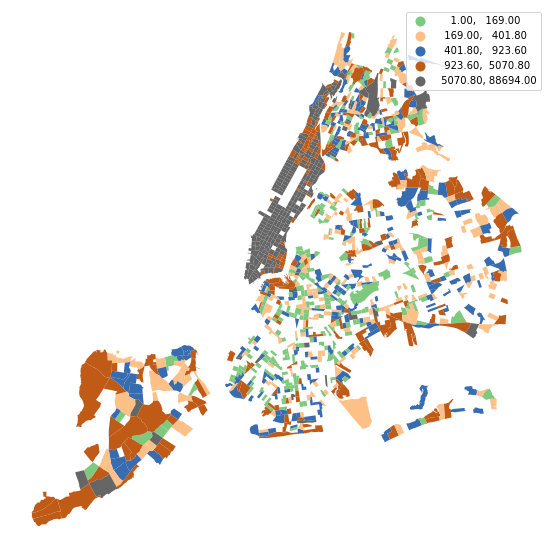

In [211]:

fig, ax = plt.subplots(figsize=(10,10))

# Plot the choropleth,threshold>0.5
plot1=gdf_mar_21.plot(ax=ax, column='raw_visit_counts',
                    scheme='Quantiles',cmap='Accent',
                    legend=True,
#                     legend_kwargs={ 'loc': 'lower right'},
                   )

# Format
# ax.set_title("visit count of NY in march 2021", fontsize=16)

# ax.legend(loc='lower left')
ax.set_axis_off()
fig.savefig('../fig/raw_visit_counts_mar_2021.jpg')

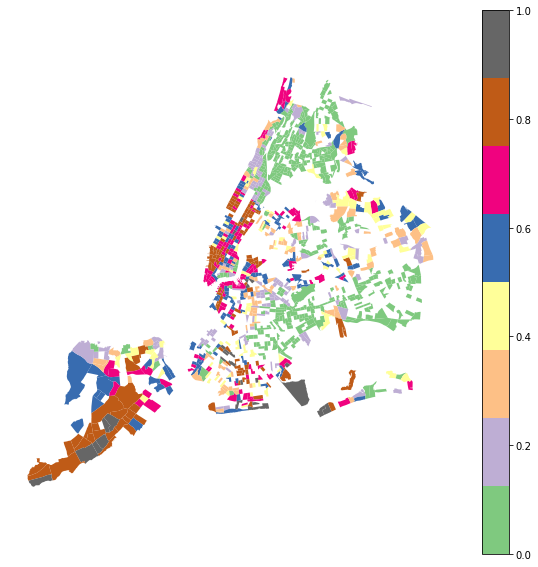

In [212]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot the choropleth
gdf_mar_21.plot(ax=ax, column='pctWhite',cmap="Accent", legend=True)

# Format
# ax.set_title("White percent of NY", fontsize=16)
ax.set_axis_off()

fig.savefig('../fig/white_percent.jpg')

In [96]:
gdf_mar_21.head(1)

,tract_id,raw_visit_counts,NAME,GEO_ID_x,total_pop,Hispanic,Whites,Black,Indian,Asian,FemaleBachelors,MaleBachelors,TotalPoverty,TotalVacant,TotalUnit,MedRent,MedHHInc,NoCar,OneCar,TwoCar,ThreeCar,FourMoreCar,TotalHousehold,state,county,tract,income_quantile,pctWhite,pctBlack,pctIndian,pctAsian,pctHispanic,pctVacant,pctBachelors,pctPoverty,average_car,GEO_ID_y,geometry
0,36005000200,493,"Census Tract 2, Bronx County, New York",1400000US36005000200,4532.00,75.00,33.00,920.00,0.00,75.00,0.00,0.00,1017.00,157.00,1499.00,1454.00,51100.00,340.00,666.00,291.00,45.00,0.00,1342.00,36,Bronx,000200,Mid,0.01,0.20,0.00,0.02,0.02,0.10,0.00,0.22,1.03,36005000200,"POLYGON ((-73.85652 40.80525, -73.85653 40.805..."


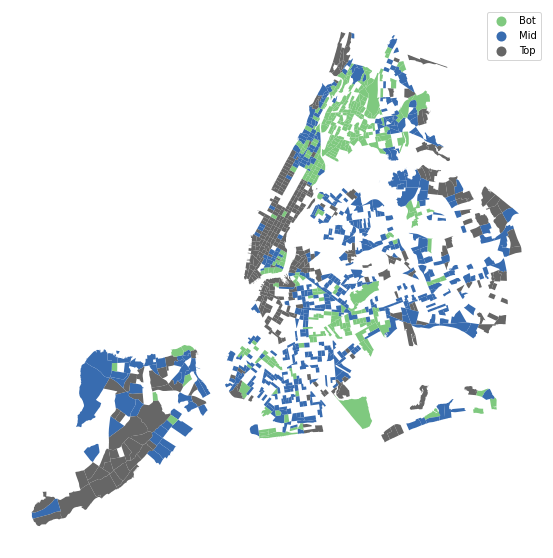

In [213]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot the choropleth
gdf_mar_21.plot(ax=ax, column='income_quantile',categorical='True', cmap="Accent", legend=True)

# Format
# ax.set_title("income higher than average in NY", fontsize=16)
ax.set_axis_off()
fig.savefig('../fig/income_high.jpg')